### Visualizing intermediate activations

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file, load_img, img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt

In [3]:
model = load_model("cat-dog-augmented.keras")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

**Preprocessing a single image**

In [18]:
def image_to_array(img_path, target_size):
    
    img = load_img(img_path, target_size=target_size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)

    return array

In [19]:
img_path = get_file(fname="cat.jpg", origin="https://img-datasets.s3.amazonaws.com/cat.jpg")
img_tensor = image_to_array(img_path, target_size=(180, 180))

**Displaying the test picture**

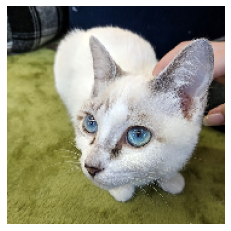

In [21]:
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

**Instantiating a model that returns layer activations**

In [34]:
layer_outputs = []
layer_names = []

for layer in model.layers:
    
    if isinstance(layer, (Conv2D, MaxPooling2D)):
        
        layer_names.append(layer.name)
        layer_outputs.append(layer.output)
        print('Layer:', layer.name, '- Output:', layer.output.shape, '\n')

activation_model = Model(inputs=model.input, outputs=layer_outputs)

Layer: conv2d_26 - Output: (None, 178, 178, 32) 

Layer: max_pooling2d_20 - Output: (None, 89, 89, 32) 

Layer: conv2d_27 - Output: (None, 87, 87, 64) 

Layer: max_pooling2d_21 - Output: (None, 43, 43, 64) 

Layer: conv2d_28 - Output: (None, 41, 41, 128) 

Layer: max_pooling2d_22 - Output: (None, 20, 20, 128) 

Layer: conv2d_29 - Output: (None, 18, 18, 256) 

Layer: max_pooling2d_23 - Output: (None, 9, 9, 256) 

Layer: conv2d_30 - Output: (None, 7, 7, 256) 



**Using the model to compute layer activations**

In [52]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 15ms/step


In [36]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


**Visualizing the fifth channel**

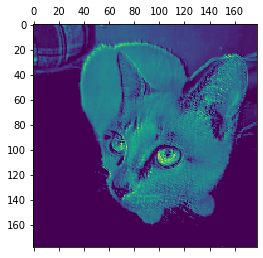

In [50]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

**Visualizing every channel in every intermediate activation**

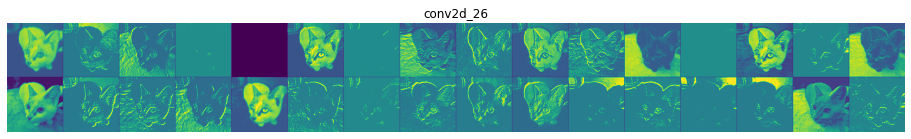

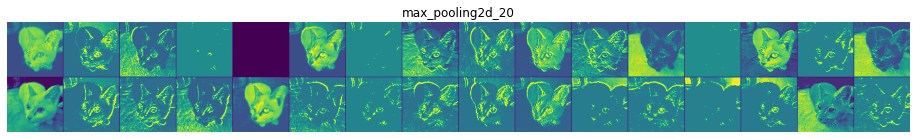

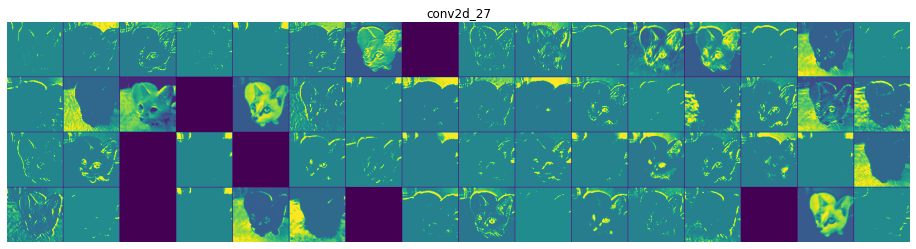

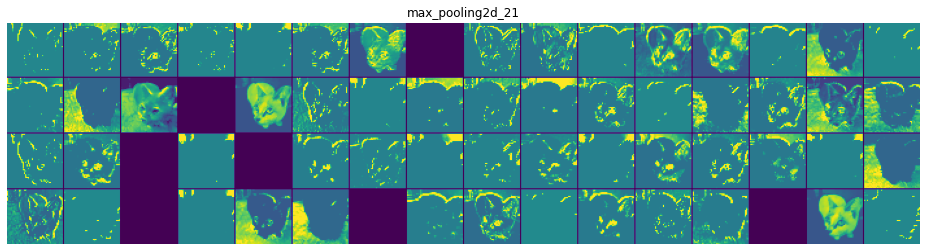

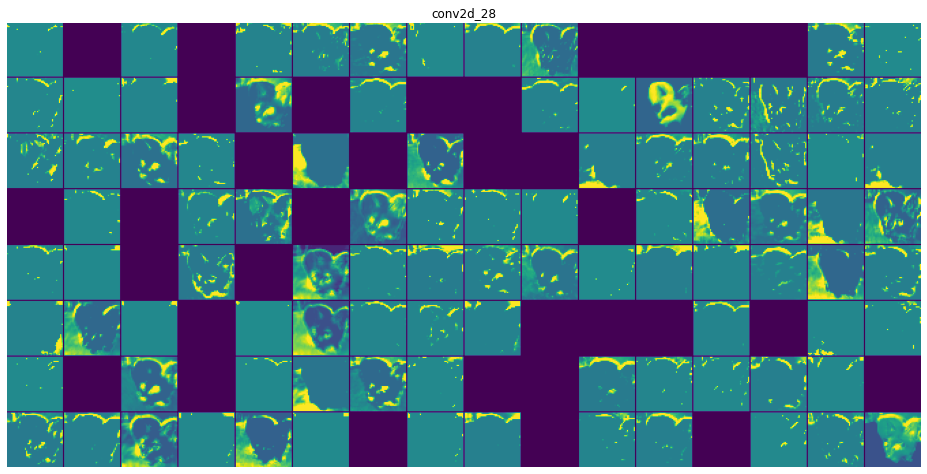

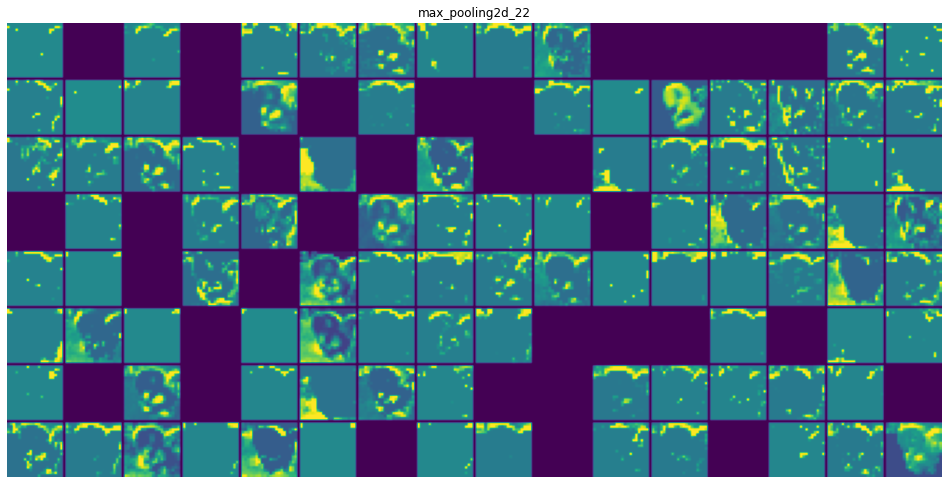

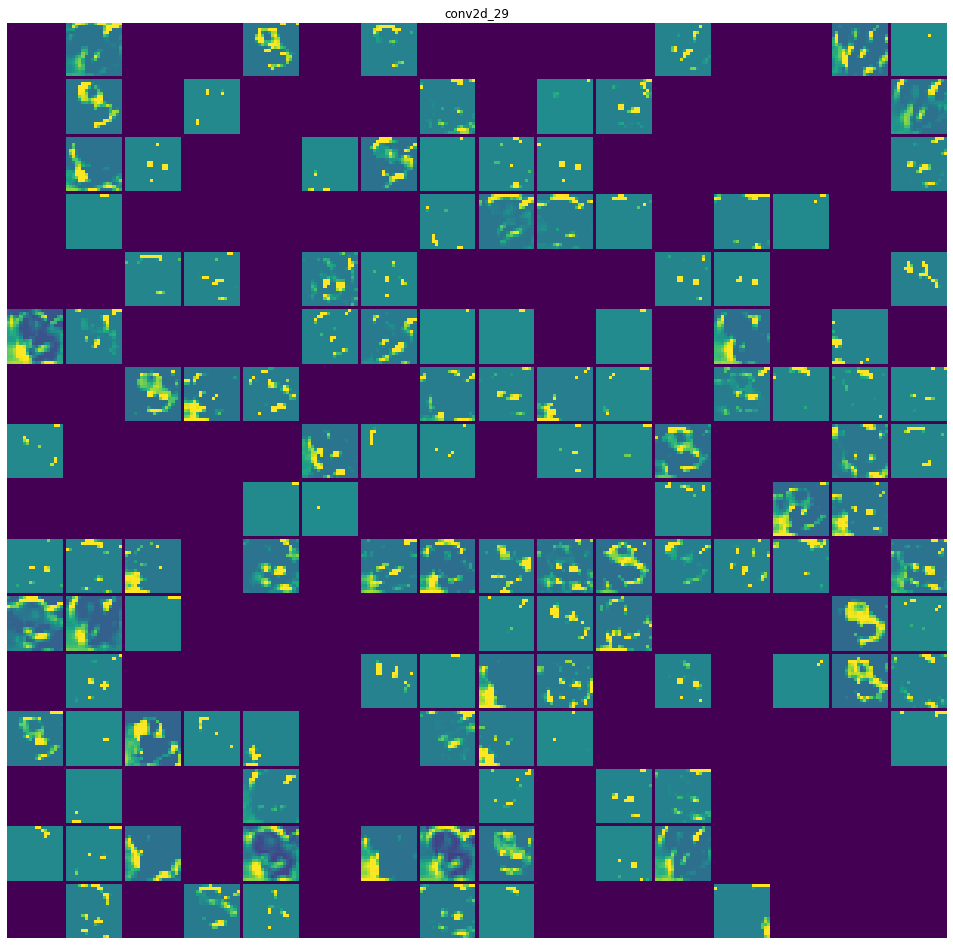

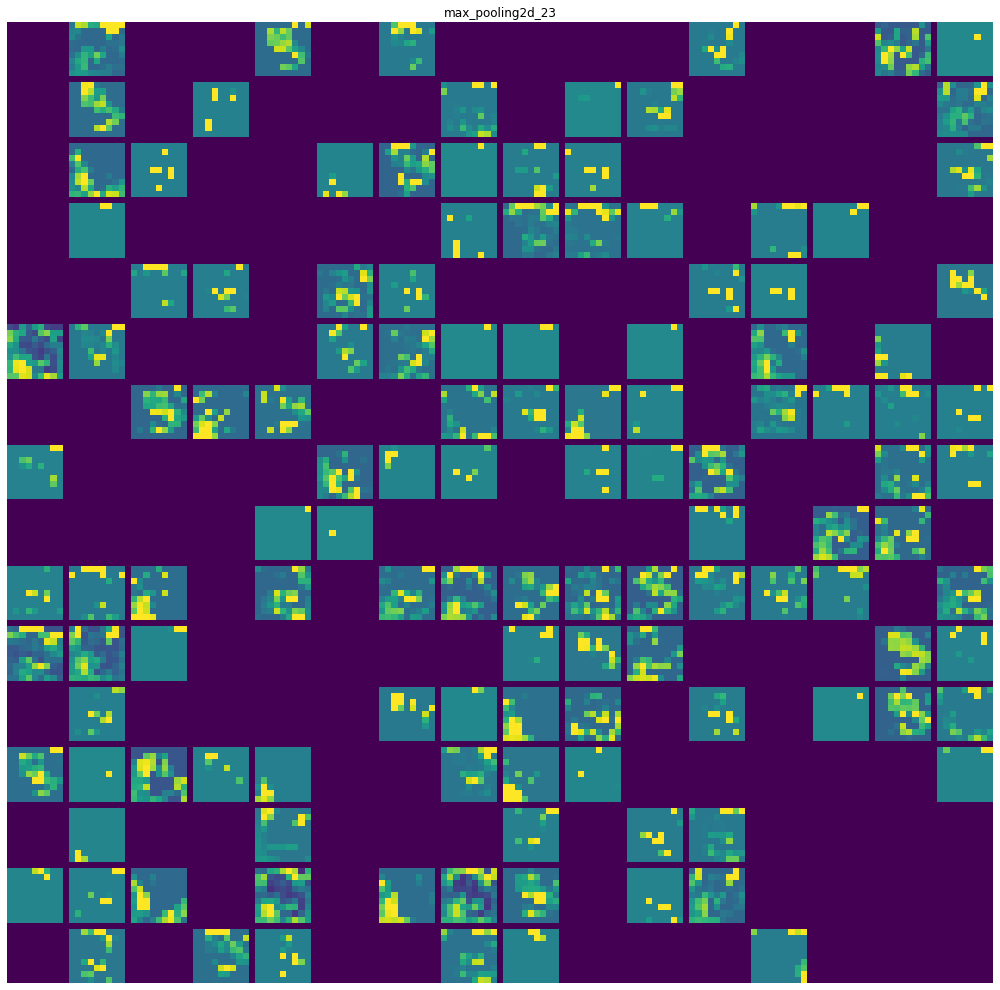

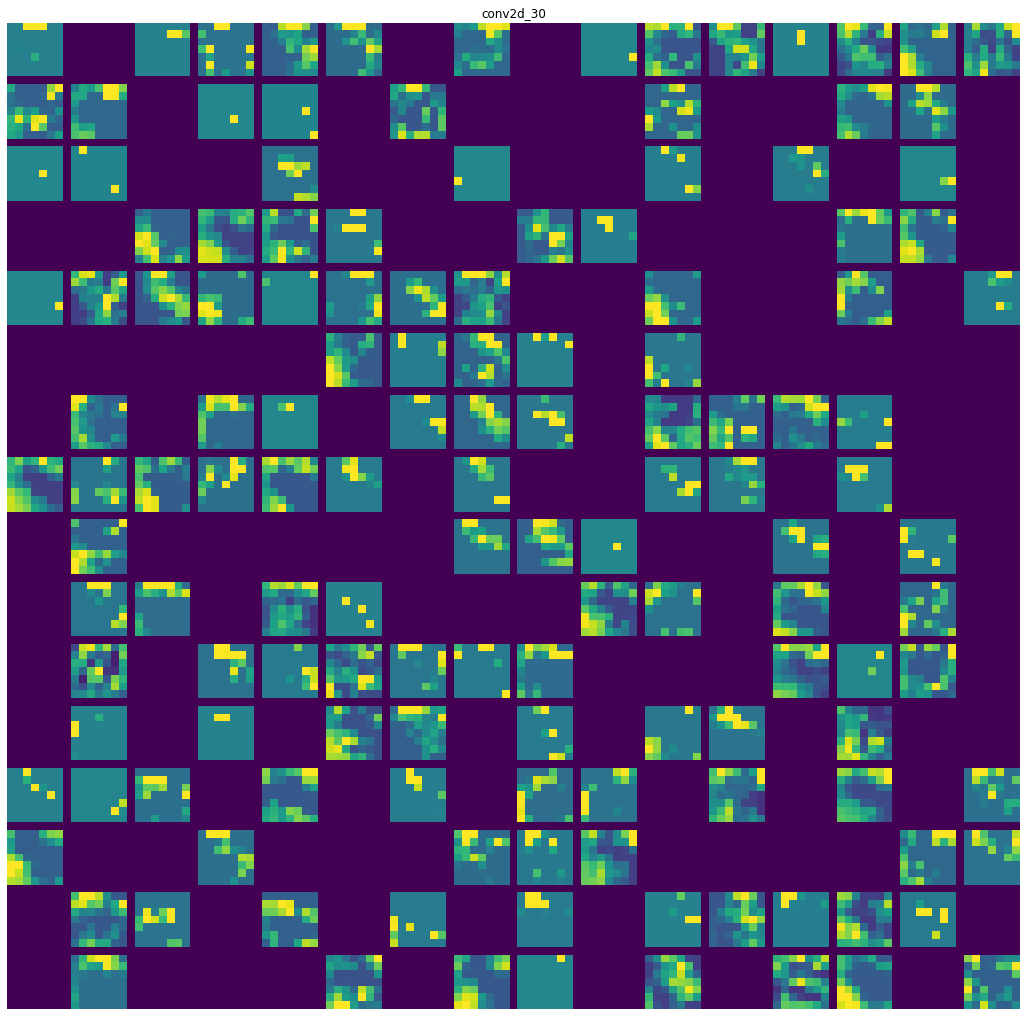

In [53]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")